In [ ]:
import pandas as pd
import numpy as np
from collections import Counter
import ast
import math
import csv
import tensorflow as tf
import keras
from keras.utils import np_utils

# from tensorflow.keras.preprocessing.text import Tokenizer
# from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Dense,
    Flatten,
    LSTM,
    Dropout,
    Activation,
    Embedding,
    Bidirectional,
)

# import and read data
full_reviews = pd.read_csv(
    "/content/train_cleaned.csv",
)


master_counter = Counter("")


def update_master(x):
    x = ast.literal_eval(x)
    for word in list(x):
        master_counter.update([word])


full_reviews["Phrase"].apply(lambda x: update_master(x))
number_of_words_total = sum(master_counter.values())
sorted_words = master_counter.most_common(number_of_words_total)

vocab_to_int = {w: i + 1 for i, (w, c) in enumerate(sorted_words)}

reviews_int = []
sentiments = []
for index, row in full_reviews.iterrows():
    review = row["Phrase"]
    sentiment = row["Sentiment"]
    r = [vocab_to_int[w] for w in list(ast.literal_eval(review))]
    reviews_int.append(r)
    sentiments.append(sentiment)


def pad_features(reviews_int, seq_length):
    """Return features of review_ints, where each review is padded with 0's or truncated to the input seq_length."""
    features = np.zeros((len(reviews_int), seq_length), dtype=int)

    for i, review in enumerate(reviews_int):
        review_len = len(review)

        if review_len <= seq_length:
            zeroes = list(np.zeros(seq_length - review_len))
            new = zeroes + review
        elif review_len > seq_length:
            new = review[0:seq_length]

        features[i, :] = np.array(new)

    return features


features = pad_features(reviews_int, 20)
len_feat = len(features)


# we need to encode 0,1,2,3,4 sentiments as one hot encodings: [1,0,0,0,0], [0,1,0,0,0], etc.
encoded_labels = np.array(sentiments)
# temp_labels = np.array(sentiments)
# encoded_labels = np.eye(5)[temp_labels.reshape(-1)]

split_frac = 0.8
train_x = features[0 : int(split_frac * len_feat)]
train_y = encoded_labels[0 : int(split_frac * len_feat)]
remaining_x = features[int(split_frac * len_feat) :]
remaining_y = encoded_labels[int(split_frac * len_feat) :]
valid_x = remaining_x[0 : int(len(remaining_x) * 0.5)]
valid_y = remaining_y[0 : int(len(remaining_y) * 0.5)]
test_x = remaining_x[int(len(remaining_x) * 0.5) :]
test_y = remaining_y[int(len(remaining_y) * 0.5) :]


vocab_size = len(vocab_to_int) + 1  # +1 for the 0 padding
output_size = 5
embedding_dim = math.ceil(vocab_size**0.25)
hidden_dim = 16
num_epochs = 10
lr = 0.001

model = Sequential()

model.add(Embedding(vocab_size, embedding_dim))
model.add(Dropout(0.5))
model.add(Bidirectional(LSTM(embedding_dim)))
model.add(Dense(output_size, activation="softmax", kernel_regularizer='l2'))

model.summary()

opt = tf.keras.optimizers.Adam(learning_rate=lr, decay=1e-6)
model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=opt,
    metrics=["accuracy"],
)

history = model.fit(
    train_x, train_y, epochs=num_epochs, batch_size=16, validation_data=(valid_x, valid_y), verbose=2
)

Model: "sequential_43"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_43 (Embedding)    (None, None, 11)          149116    
                                                                 
 dropout_47 (Dropout)        (None, None, 11)          0         
                                                                 
 bidirectional_45 (Bidirecti  (None, 22)               2024      
 onal)                                                           
                                                                 
 dense_65 (Dense)            (None, 5)                 115       
                                                                 
Total params: 151,255
Trainable params: 151,255
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
426/426 - 9s - loss: 1.6073 - accuracy: 0.2664 - val_loss: 1.5825 - val_accuracy: 0.2797 - 9s/epoch - 

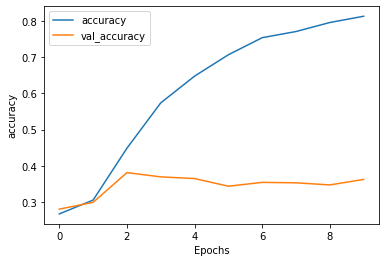

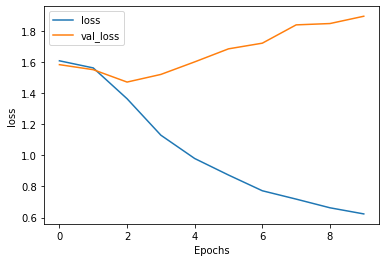

In [ ]:
import matplotlib.pyplot as plt

def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [ ]:
print("Evaluate on test data")
results = model.evaluate(test_x, test_y, batch_size=16)
print("test loss, test acc:", results)

Evaluate on test data
54/54 [==============================] - 0s 7ms/step - loss: 1.9118 - accuracy: 0.3756
test loss, test acc: [1.911807656288147, 0.3755868673324585]
